# Lienar Kalman filter

In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
variable = sio.loadmat("./kf_practical/data/sensor_data.mat")

In [3]:
for k, v in variable.items():
    print(k)

__header__
__version__
__globals__
data
variableNames


In [4]:
print(variable["variableNames"])
print(len(variable["variableNames"][0]))
print(len(variable["data"][0]))

[[array(['Timestamp [s]'], dtype='<U13')
  array(['Global X [m]'], dtype='<U12')
  array(['Global Y [m]'], dtype='<U12') array(['Range [m]'], dtype='<U9')
  array(['Bearing [rad]'], dtype='<U13')]]
5
5


In [5]:
column_name = [i[0].split(" ")[0] for i in variable["variableNames"][0]]
column_name[1] += " X"
column_name[2] += " Y"
column_name

['Timestamp', 'Global X', 'Global Y', 'Range', 'Bearing']

In [6]:
raw_data = np.vstack([i for i in variable["data"]]);
print(raw_data.shape)

(1031, 5)


In [7]:
sensor_data = pd.DataFrame(columns=column_name, data=raw_data)
sensor_data.head(5)

,Timestamp,Global X,Global Y,Range,Bearing
0,0.0,179.820254,276.504102,148.715430,1.008220
1,0.1,179.684454,275.593219,148.637634,1.004353
2,0.2,179.947281,274.939092,148.496555,1.003498
3,0.3,179.805348,274.329455,149.586602,1.000930
4,0.4,180.460459,273.344521,148.655644,0.995270


In [8]:
variable = sio.loadmat("./kf_practical/data/groundtruth.mat")
for k, v in variable.items():
    print(k)

__header__
__version__
__globals__
gt
variableNames


In [9]:
column_name = [i[0].split(" ")[0] for i in variable["variableNames"][0]]
column_name[1] += " X"
column_name[2] += " Y"
column_name

['Timestamp', 'Global X', 'Global Y', 'Range', 'Bearing']

In [10]:
raw_data = np.vstack([i for i in variable["gt"]]);
print(raw_data.shape)

(1031, 5)


In [11]:
groundTruth = pd.DataFrame(data=raw_data, columns=column_name)
groundTruth.head(5)

,Timestamp,Global X,Global Y,Range,Bearing
0,0.0,179.807477,276.261422,149.369274,1.007121
1,0.1,179.898912,275.593810,148.854430,1.004206
2,0.2,179.990348,274.907654,148.325243,1.001202
3,0.3,180.081783,274.221497,147.797403,0.998178
4,0.4,180.173218,273.535341,147.270925,0.995131


# Linear Kalman Filter

In [12]:
sigma_X = sensor_data["Global X"] - groundTruth["Global X"]
sigma_Y = sensor_data["Global Y"] - groundTruth["Global Y"]
sigma_X = sigma_X.std()
sigma_Y = sigma_Y.std()
print(sigma_X)
print(sigma_Y)

0.5016108099419974
0.25997987805366085


In [13]:
dt = 0.1
# State transition matrix
# F = np.array([[1, dt, 0, 0],
#               [0,  1, 0, 0],
#               [0, 0, 1, dt],
#               [0, 0, 0,  1]])
F = np.array([[1, dt, 0, 0],
              [0,  1, 0, 0],
              [0, 0, 1, dt],
              [0, 0, 0,  1]])
# F = np.array([[1, 0],
#               [0, 1]])
# measurement matrix
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])


In [14]:
R = np.array([[sigma_X**2,0],
              [0, sigma_Y**2]])

In [15]:
vx = np.gradient(sensor_data["Global X"].to_numpy())
vy = np.gradient(sensor_data["Global Y"].to_numpy())
ax = np.gradient(vx)
ay = np.gradient(vy)

In [16]:
ax_m = np.mean(ax)
ay_m = np.mean(ay)

In [17]:
ds_x = 0.5 * ax_m * dt ** 2
ds_y = 0.5 * ay_m * dt ** 2
dv_x = ax_m * dt
dv_y = ay_m * dt

In [18]:
# Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
#              [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
#              [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
#              [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]
Q = np.array([[0, 0.001, 0, 0],
              [0.001, 0.001, 0, 0],
              [0, 0, 0, 0.001],
              [0, 0, 0.001, 0.001]])

In [19]:
# P = np.array([[100, 0],
#               [0, 100]])
P = np.diag([500]*4)
x = np.array([[179.807477], 
              [0],
              [276.261422],
              [0]])

In [20]:
xs = []
cov = []

In [21]:
for i in range(len(raw_data)):
    # Predict
    x = F.dot(x)
    P = F.dot(P).dot(F.T) + Q
    
    # update
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H.T).dot(np.linalg.pinv(S))
    z = np.array([[sensor_data["Global X"][i]], 
                  [sensor_data["Global Y"][i]]])
    y = z - H.dot(x)
    x = x + K.dot(y)
    P = P - K.dot(H).dot(P)
    xs.append(x)
    cov.append(P)
    

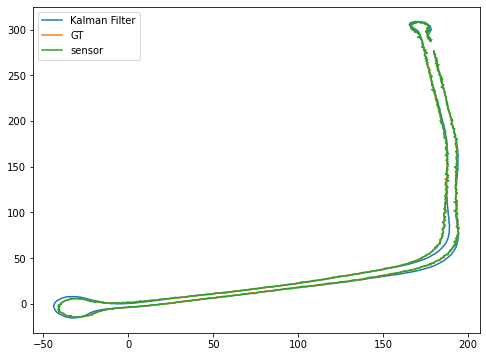

In [22]:
plt.figure(figsize = (8,6))

npxs = np.array(xs).reshape(-1, 4).T
plt.plot(npxs[0,:], npxs[2,:], label = "Kalman Filter")
plt.plot(groundTruth["Global X"], groundTruth["Global Y"], label = "GT")
plt.plot(sensor_data["Global X"], sensor_data["Global Y"], label = "sensor")
plt.legend()

In [23]:
import plotly.express as px

In [24]:
df = pd.DataFrame(data = np.array(xs).reshape(-1,4), columns = ["X", "vx", "Y", "vy"])
df.head(5)

,X,vx,Y,vy
0,179.820248,0.001264,276.504069,0.024025
1,179.690720,-1.232064,275.605353,-8.864816
2,179.879239,0.619006,274.901619,-7.771262
3,179.846717,0.215843,274.267672,-7.158047
4,180.222315,1.393967,273.427639,-7.572260


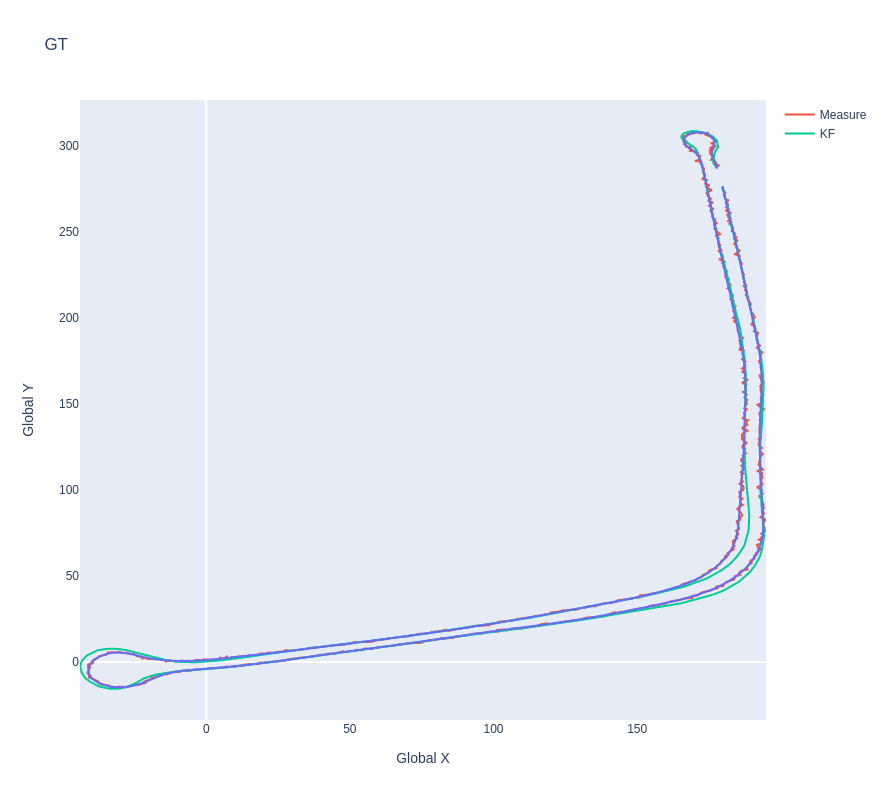

In [33]:
fig = px.line(groundTruth, x="Global X", y="Global Y", title='GT',  width=800, height=800)
fig.add_scatter(x=sensor_data['Global X'], y=sensor_data['Global Y'], mode='lines', name="Measure")
fig.add_scatter(x=df['X'], y=df['Y'], mode='lines', name = "KF")
fig.update_layout(xaxis=dict(showgrid=False),
              yaxis=dict(showgrid=False)
)

fig.show()

In [28]:
# TODO
# Smooth

# Extended Kalman Filter

In [34]:
sigma_r = sensor_data["Range"] - groundTruth["Range"]
sigma_theta = sensor_data["Bearing"] - groundTruth["Bearing"]
sigma_r = sigma_r.std()
sigma_theta = sigma_theta.std()
print(sigma_r)
print(sigma_theta)

0.49940904174868217
0.0010021996203754986
